In [1]:
import pickle
import os
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures


gleap_target = md.load("../2_md-preparation/gleap.target.gro")
target_indices = gleap_target.topology.select("resid 0 to 48")

protein_indices = gleap_target.topology.select("resid 5 to 48")
protein_region_indices = {
    "idr": gleap_target.topology.select("resid 5 to 14"),
    "structured": gleap_target.topology.select("resid 15 to 48"),
}
protein_min_index = min(protein_indices)

rna_indices = gleap_target.topology.select("resid 0 to 4")
rna_min_index = min(rna_indices)

charged_atoms = {
    "protein": {
        "positive": gleap_target.topology.select("resid 5 to 48 and ((rescode R and (name NH1 or name NH2)) or (rescode K and name NZ) or (resname HIP and (name ND1 or name NE2)))"),
        "negative": gleap_target.topology.select("resid 5 to 48 and (rescode D and (name OD1 or name OD2) or (rescode E and (name OE1 or name OE2)))")
    },
    "rna": {
        "positive": [],
        "negative": gleap_target.topology.select("resid 0 to 4 and (name OP1 or name OP2)")
    }
}

pickle_dir = "./pickle-cache/charge-attraction"

if False:
    def worker(trial):
        print(trial, "start")
        interactions = np.zeros((len(protein_indices), len(rna_indices), 1200))
        com_dists_hist = np.zeros(1200)
        cmd_com_dists_average = 0
        cmd_interactions = np.zeros((len(protein_indices), len(rna_indices), 8000))

        xtc = None
        if trial == "cmd":
            xtc = md.load("../6_prd-1/prd.skip10.whole.cluster.xtc", top=gleap_target, atom_indices=target_indices)[2001:]
        else:
            xtc = md.load(f"./trial{str(trial+1).zfill(3)}/prd.target.trjcat-all.mol.pbc.skip10.xtc", top=gleap_target)
    
        protein_coms = md.compute_center_of_mass(xtc.atom_slice(protein_indices))
        rna_coms     = md.compute_center_of_mass(xtc.atom_slice(    rna_indices))
    
        com_dists = np.linalg.norm(rna_coms-protein_coms, axis=1)
        com_dists_hist = np.zeros(1200)
        for com_dist in com_dists:
            com_dist_bin = int(com_dist*100)
            com_dists_hist[com_dist_bin]+=1
    
        for protein_idx in charged_atoms["protein"]["positive"]:
            for rna_idx in charged_atoms["rna"]["negative"]:
                distances = np.linalg.norm(xtc.xyz[:,protein_idx]-xtc.xyz[:,rna_idx], axis=1)
                for timestep in range(len(distances)):
                    if distances[timestep] < 0.4:
                        if trial == "cmd":
                            cmd_interactions[protein_idx-protein_min_index][rna_idx][timestep] += 1
                        else:
                            com_dist_bin = int(com_dists[timestep]*100)
                            interactions[protein_idx-protein_min_index][rna_idx][com_dist_bin] += 1

        if trial == "cmd":
            cmd_com_dists_average = np.average(com_dists)
            pickle.dump(cmd_com_dists_average, open(f"{pickle_dir}/cmd_com_dists_average.pickle", "wb"))
            nonzero_idxs = cmd_interactions.nonzero()
            nonzero_vals = cmd_interactions[nonzero_idxs]
            pickle.dump([nonzero_idxs, nonzero_vals], open(f"{pickle_dir}/cmd_interactions.pickle", "wb"))
        else:  
            nonzero_idxs = interactions.nonzero()
            nonzero_vals = interactions[nonzero_idxs]
            pickle.dump([nonzero_idxs, nonzero_vals], open(f"{pickle_dir}/pacs_interactions_{trial}.pickle", "wb"))
            pickle.dump(com_dists_hist, open(f"{pickle_dir}/pacs_com_dists_hist_{trial}.pickle", "wb"))
        print(trial, "completed")

    if not os.path.exists(pickle_dir):
        os.mkdir(pickle_dir)
    trials = ["cmd"]
    trials.extend(range(32))
    for _ in concurrent.futures.ProcessPoolExecutor(max_workers=20).map(worker, trials):
        pass

pacs_interactions = np.zeros((32, len(protein_indices), len(rna_indices), 1200))
pacs_com_dists_hist = np.zeros((32, 1200))
for trial in range(len(pacs_interactions)):
    nonzero_idxs, nonzero_vals = pickle.load(open(f"{pickle_dir}/pacs_interactions_{trial}.pickle", "rb"))
    pacs_interactions[trial][nonzero_idxs] = nonzero_vals
    pacs_com_dists_hist[trial] = pickle.load(open(f"{pickle_dir}/pacs_com_dists_hist_{trial}.pickle", "rb"))
cmd_com_dists_average = pickle.load(open(f"{pickle_dir}/cmd_com_dists_average.pickle", "rb"))
cmd_interactions = np.zeros((len(protein_indices), len(rna_indices), 8000))
nonzero_idxs, nonzero_vals = pickle.load(open(f"{pickle_dir}/cmd_interactions.pickle", "rb"))
cmd_interactions[nonzero_idxs] = nonzero_vals

cmd_com_dists_average 1.0243714360087497
average 0 0.0
average 0 0.0
average 1 0.00025
average 1 0.0
average 2 0.0
average 2 0.0
average 3 0.0
average 3 0.0
average 4 0.0
average 4 0.0


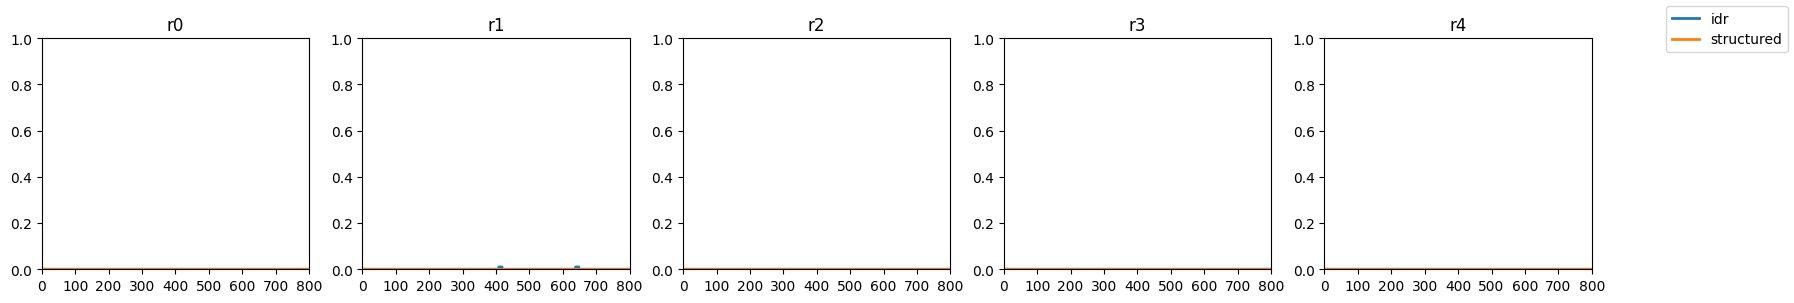

In [2]:
ymax = 1

print("cmd_com_dists_average", cmd_com_dists_average)
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(20, 3)

for rna_res_idx in range(0, 5):
    rna_res_atom_idxs = gleap_target.topology.select(f"resid {rna_res_idx}")
    min_rna_res_atom_idx = min(rna_res_atom_idxs)
    max_rna_res_atom_idx = max(rna_res_atom_idxs)

    for region_name, region_indices in protein_region_indices.items():
        sum_cmd_interactions = np.sum(np.sum(cmd_interactions[region_indices-protein_min_index,min_rna_res_atom_idx-rna_min_index:max_rna_res_atom_idx+1-rna_min_index,:], axis=0), axis=0)
        smoothed_interactions = np.zeros(len(sum_cmd_interactions))
        for timestep in range(50, len(sum_cmd_interactions)-50):
            smoothed_interactions[timestep] = np.average(sum_cmd_interactions[timestep-50:timestep+50])
            
        print("average", rna_res_idx, np.average(sum_cmd_interactions))
        ax[rna_res_idx-0].set_title(f"r{rna_res_idx-0}")
        ax[rna_res_idx-0].set_xticks([val*1000 for val in range(9)], [val*100 for val in range(9)])
        if rna_res_idx == 0:
            ax[rna_res_idx-0].plot(smoothed_interactions, linewidth=2, label=region_name)
        else:
            ax[rna_res_idx-0].plot(smoothed_interactions, linewidth=2)
        ax[rna_res_idx-0].set_xlim(0, 8000)
        ax[rna_res_idx-0].set_ylim(0, ymax)
fig.legend()

/tmp/ipykernel_2052121/52205945.py:21: RuntimeWarning: invalid value encountered in divide
  ax[ax_row][rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/pacs_com_dists_hist[trial], linewidth=2)
/tmp/ipykernel_2052121/52205945.py:21: RuntimeWarning: invalid value encountered in divide
  ax[ax_row][rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/pacs_com_dists_hist[trial], linewidth=2)
/tmp/ipykernel_2052121/52205945.py:21: RuntimeWarning: invalid value encountered in divide
  ax[ax_row][rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/pacs_com_dists_hist[trial], linewidth=2)
/tmp/ipykernel_2052121/52205945.py:21: RuntimeWarning: invalid value encountered in divide
  ax[ax_row][rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/pacs_com_dists_hist[trial], linewidth=2)
/tmp/ipykernel_2052121/52205945.py:21: RuntimeWarning: invalid value encountered in divide
  ax[ax_row][rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/pacs_com_dists_hist[trial], linewidt

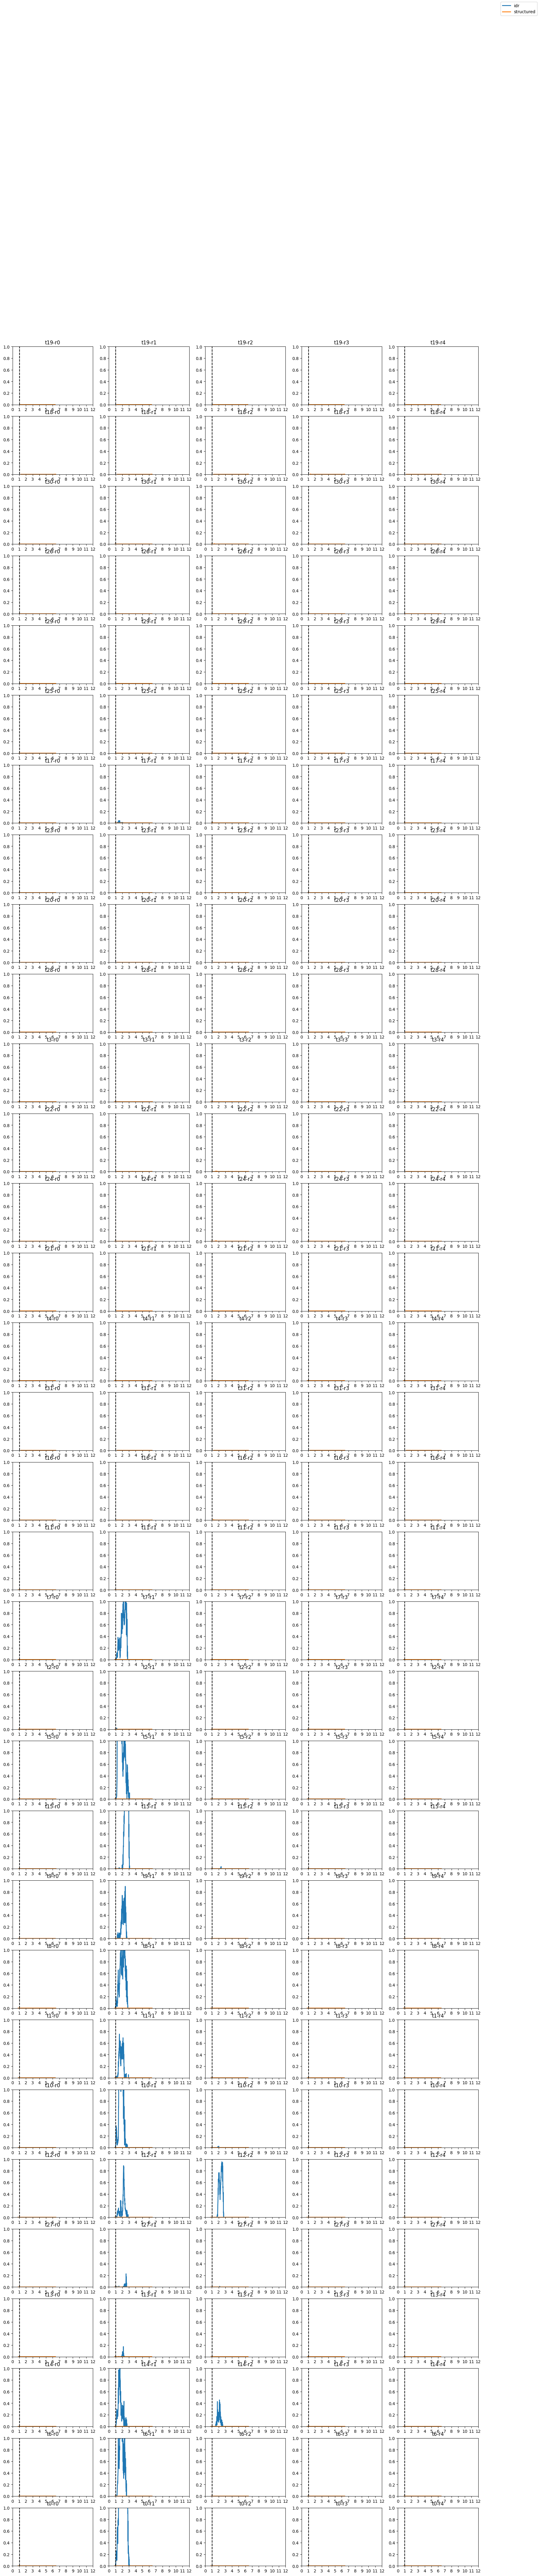

In [3]:
fig, ax = plt.subplots(len(pacs_interactions), 5)
fig.set_size_inches(20, 3*len(pacs_interactions))

pacs_g_stds_ordered = [(19, -3.4383222715529755), (18, -4.064455225716387), (30, -4.48612942287419), (26, -4.624781171615315), (29, -4.683410979897177), (25, -4.933236290336003), (17, -5.118835703750063), (23, -5.521004724688876), (20, -5.522645853979005), (28, -5.678007148970815), (3, -5.678261127542603), (22, -5.93031226290956), (24, -5.966115973285376), (21, -6.022353770917038), (4, -6.125216702283895), (31, -6.224672440089437), (16, -6.2739255360777175), (11, -6.287913880137764), (7, -6.520357463407324), (2, -6.873004446601907), (5, -7.305598346706374), (15, -7.425622465131511), (9, -7.442437949729127), (8, -7.627195073788825), (1, -8.100851065532183), (10, -8.265797922888845), (12, -8.413117936507568), (27, -8.424109846287314), (13, -9.041054919020613), (14, -9.094471340851847), (6, -9.28998243345896), (0, -10.433896108969531)]

ax_row = 0
for trial, g_std in pacs_g_stds_ordered:
    for region_name, region_indices in protein_region_indices.items():
        rna_interactions_sum = np.zeros((28, 1200))
        for rna_idx in rna_indices:
            rna_res_idx = gleap_target.topology.atom(rna_idx).residue.index
            if not (0 <= rna_res_idx <= 4):
                continue
            for protein_idx in region_indices:
                rna_interactions_sum[rna_res_idx-0] += pacs_interactions[trial][protein_idx-protein_min_index][rna_idx-rna_min_index]
    
        for rna_res_idx in range(0, 5):
            if trial == 0 and rna_res_idx == 0:
                ax[ax_row][rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/pacs_com_dists_hist[trial], linewidth=2, label=region_name)
            else:
                ax[ax_row][rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/pacs_com_dists_hist[trial], linewidth=2)
            ax[ax_row][rna_res_idx-0].set_title(f"t{trial}-r{rna_res_idx-0}")
            ax[ax_row][rna_res_idx-0].set_xticks([val*100 for val in range(13)], [val for val in range(13)])
            ax[ax_row][rna_res_idx-0].set_ylim(0, ymax)
            ax[ax_row][rna_res_idx-0].axvline(cmd_com_dists_average*100, color="black", linestyle="--")
    ax_row += 1
fig.legend()

/tmp/ipykernel_2052121/3804007334.py:36: RuntimeWarning: invalid value encountered in divide
  ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=3, label=region_name, c=colors[region_name][category_name])
/tmp/ipykernel_2052121/3804007334.py:38: RuntimeWarning: invalid value encountered in divide
  ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=3, c=colors[region_name][category_name])
/tmp/ipykernel_2052121/3804007334.py:38: RuntimeWarning: invalid value encountered in divide
  ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=3, c=colors[region_name][category_name])
/tmp/ipykernel_2052121/3804007334.py:38: RuntimeWarning: invalid value encountered in divide
  ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=3, c=colors[region_nam

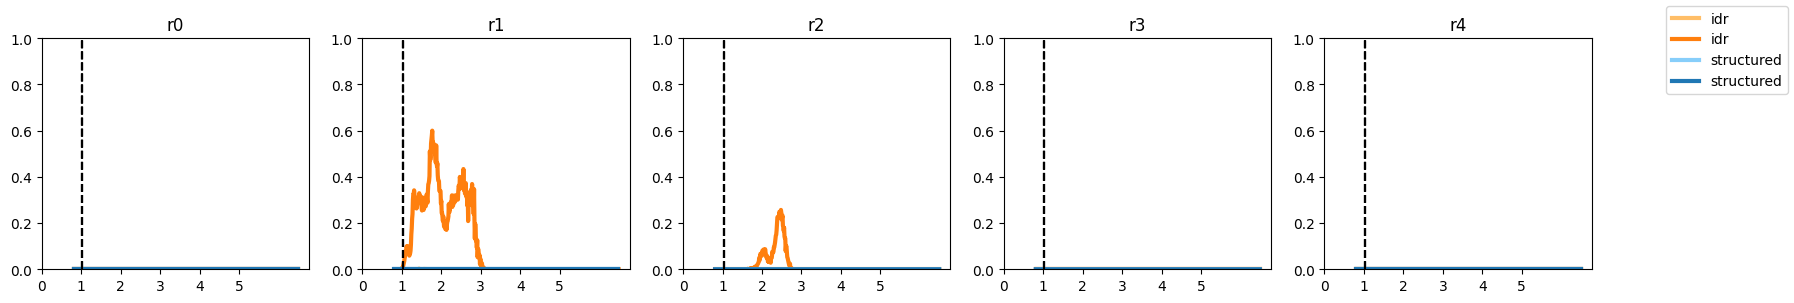

In [4]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(20, 3)

colors = {
    "idr": {
        "high": "#FFBE67",
        "low": "tab:orange",
    },
    "structured": {
        "high": "lightskyblue",
        "low": "tab:blue",
    },
}

pacs_category = {"high": [], "low": []}
for i in range(len(pacs_g_stds_ordered)):
    if i < 13:
        pacs_category["high"].append(pacs_g_stds_ordered[i][0])
    else:
        pacs_category["low"].append(pacs_g_stds_ordered[i][0])

for region_name, region_indices in protein_region_indices.items():
    for category_name, trials in pacs_category.items():
        rna_interactions_sum = np.zeros((28, 1200))
        for trial in trials:
            for rna_idx in rna_indices:
                rna_res_idx = gleap_target.topology.atom(rna_idx).residue.index
                if not (0 <= rna_res_idx <= 4):
                    continue
                for protein_idx in region_indices:
                    rna_interactions_sum[rna_res_idx-0] += pacs_interactions[trial][protein_idx-protein_min_index][rna_idx-rna_min_index]
                        
        for rna_res_idx in range(0, 5):
            ax[rna_res_idx-0].set_title(f"r{rna_res_idx-0}")
            if rna_res_idx == 0:
                ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=3, label=region_name, c=colors[region_name][category_name])
            else:
                ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=3, c=colors[region_name][category_name])
            ax[rna_res_idx-0].set_xticks([val*100 for val in range(6)], [val for val in range(6)])
            ax[rna_res_idx-0].set_ylim(0, ymax)
            ax[rna_res_idx-0].axvline(cmd_com_dists_average*100, color="black", linestyle="--")
fig.legend()

/tmp/ipykernel_2052121/2875624476.py:20: RuntimeWarning: invalid value encountered in divide
  ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=4, label=region_name, c=colors[region_name][category_name])
/tmp/ipykernel_2052121/2875624476.py:22: RuntimeWarning: invalid value encountered in divide
  ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=4, c=colors[region_name][category_name])
/tmp/ipykernel_2052121/2875624476.py:22: RuntimeWarning: invalid value encountered in divide
  ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=4, c=colors[region_name][category_name])
/tmp/ipykernel_2052121/2875624476.py:22: RuntimeWarning: invalid value encountered in divide
  ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=4, c=colors[region_nam

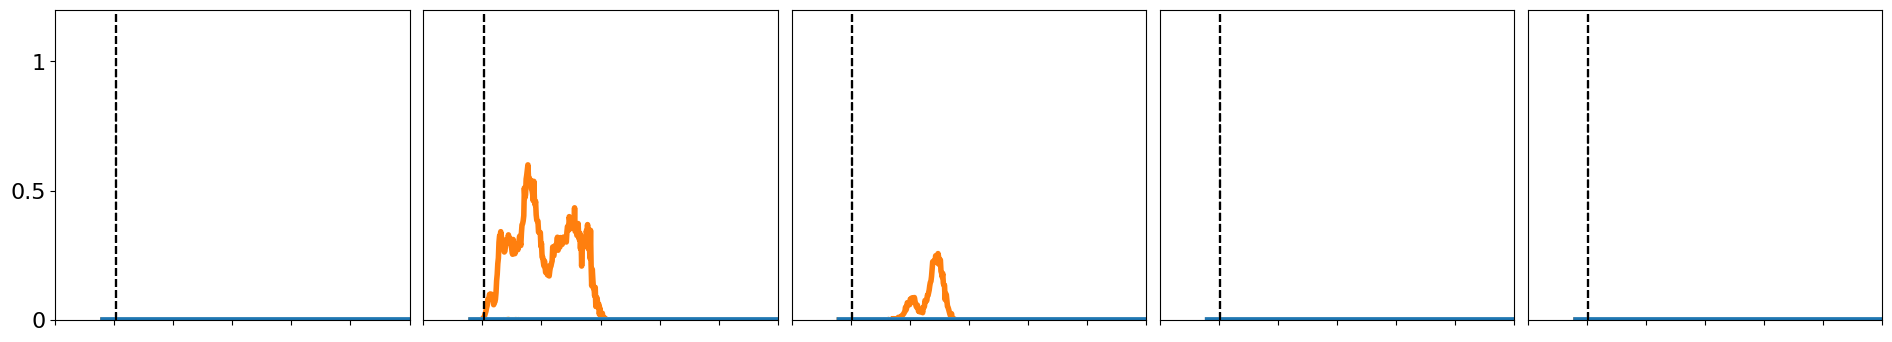

In [5]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(19, 3.5)

for region_name, region_indices in protein_region_indices.items():
    for category_name, trials in pacs_category.items():
        rna_interactions_sum = np.zeros((5, 1200))
        for trial in trials:
            for rna_idx in rna_indices:
                rna_res_idx = gleap_target.topology.atom(rna_idx).residue.index
                if not (0 <= rna_res_idx <= 4):
                    continue
                for protein_idx in region_indices:
                    rna_interactions_sum[rna_res_idx-0] += pacs_interactions[trial][protein_idx-protein_min_index][rna_idx-rna_min_index]
                        
        for rna_res_idx in range(0, 5):
            if rna_res_idx != 0:
                ax[rna_res_idx].set_yticks([])
            ax[0].set_yticks([0, 0.5, 1], [0, 0.5, 1], fontsize=16)
            if rna_res_idx == 0:
                ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=4, label=region_name, c=colors[region_name][category_name])
            else:
                ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=4, c=colors[region_name][category_name])
            ax[rna_res_idx].set_xticks([val*100 for val in range(7)], ["" for val in range(7)], fontsize=16)
            ax[rna_res_idx].set_xlim(0, 600)
            ax[rna_res_idx-0].set_ylim(0, 1.2)
            ax[rna_res_idx-0].axvline(cmd_com_dists_average*100, color="black", linestyle="--")
fig.tight_layout(pad=1, w_pad=1, h_pad=0.5)

In [6]:
for protein_res_idx in range(5, 48):
    protein_atom_idxs = gleap_target.topology.select(f"resid {protein_res_idx}")
    for protein_atom_idx in protein_atom_idxs:
        sum_interactions = np.sum(pacs_interactions[:,protein_atom_idx-protein_min_index,:,:])
        if sum_interactions != 0:
            print(gleap_target.topology.atom(protein_atom_idx), sum_interactions)

ARG15-NH1 49673.0
ARG15-NH2 82224.0
ARG34-NH2 11.0
